In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')
from collections import deque 

from dfibert.tracker.nn.rl import Agent, DQN
from dfibert.data import DataPreprocessor
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.cache import save_vtk_streamlines
from dipy.core.gradients import gradient_table
from dfibert.envs._state import TractographyState
from tqdm import trange 
from dipy.tracking import utils
import dipy.reconst.dti as dti

import matplotlib.pyplot as plt
%matplotlib notebook
%cd ..
#from train import load_model

/Users/jos/deepFibreTrackingMerge/deepFibreTrackingJos


# Environment

In [3]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, dataset = '100307', device = 'cpu', seeds = None, tracking_in_RAS = False, odf_state = False)

Loading dataset #  100307


/Users/jos/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/dipy/core/gradients.py:300: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (990.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


sphere_odf = sphere_action = repulsion100
Computing ODF


/Users/jos/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/dipy/core/gradients.py:300: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (990.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


interpolateRawDWIatState


In [4]:
env._init_shmcoeff()

# Tracking
## Analysis of tracking on subset of streamlines
The next cell carries out a ground-truth tracking workflow.

In [5]:
streamlines = []
for i in trange(100):
    terminal = False
    all_states = []
    state = env.reset(seed_index=i)
    current_direction = None
    all_states.append(state.getCoordinate().numpy())
    terminal = False
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        state, reward, terminal, _  = env.step(action.reshape(-1,1))
        all_states.append(state.getCoordinate().squeeze(0).numpy())

    state = env.reset(seed_index=i, terminal_F=True)
    current_direction = None
    terminal = False
    all_states = all_states[::-1]
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        #action = gt_actions[i]
        state, reward, terminal, _  = env.step(action.reshape(-1,1), direction="backward")
        if False in torch.eq(state.getCoordinate().squeeze(0), my_position):
            all_states.append(state.getCoordinate().squeeze(0).numpy())
            
    streamlines.append(np.asarray(all_states))

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.79it/s]


## Visualize our streamlines

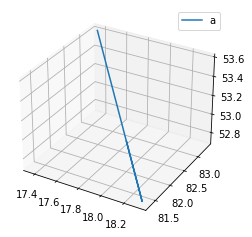

In [9]:
%matplotlib inline
streamline_index = 9
streamline_np = np.stack(streamlines[streamline_index])

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(streamline_np[:,0], streamline_np[:,1], streamline_np[:,2])
#plt.legend(['gt', 'agent'])
plt.legend('agent')

## Evaluation on ISMRM data
The next cell conducts tracking on ISMRM evaluation data.

In [7]:
dataset = DataPreprocessor().get_ismrm("data/ISMRM2015")
gtab = gradient_table(dataset.bvals, dataset.bvecs)
dti_model = dti.TensorModel(gtab, fit_method='LS')
dti_fit = dti_model.fit(dataset.dwi, mask=dataset.binary_mask)
fa_img = dti_fit.fa

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=np.eye(4), density=1) # tracking in IJK

In [8]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, device = 'cpu', seeds = torch.FloatTensor(seeds), tracking_in_RAS = False, odf_state = False)
env.dataset = DataPreprocessor().fa_estimate().preprocess(dataset)
env._init_odf()
env.reset(seed_index=0)

Loading dataset #  100307


KeyboardInterrupt: 

In [ ]:
streamlines = []
for i in trange(len(seeds)):
    terminal = False
    all_states = []
    state = env.reset(seed_index=i)
    current_direction = None
    all_states.append(state.getCoordinate().numpy())
    terminal = False
    eval_steps = 0
    while not terminal:        
        # current position
        my_position = state.getCoordinate().double().squeeze(0)
        # get best choice from environment
        action = env._get_best_action(current_direction, my_position)
        # store tangent for next time step
        current_direction = env.directions[action].numpy()
        # take a step
        state, reward, terminal, _  = env.step(action)
        all_states.append(state.getCoordinate().squeeze(0).numpy())
        eval_steps = eval_steps + 1

    state = env.reset(seed_index=i, terminal_F=True)
    current_direction = None
    terminal = False
    all_states = all_states[::-1]
    while not terminal:
        # current position
        my_position = state.getCoordinate().double().squeeze(0)
        # get best choice from environment
        action = env._get_best_action(current_direction, my_position)
        # store tangent for next time step
        current_direction = env.directions[action].numpy()
        # take a step
        state, reward, terminal, _  = env.step(action, direction="backward")
        if torch.equal(state.getCoordinate().squeeze(0), my_position):
            all_states.append(state.getCoordinate().squeeze(0).numpy())
            
    streamlines.append(np.asarray(all_states))

In [ ]:
%matplotlib notebook
streamline_index = 0
streamline_np = np.stack(streamlines[streamline_index])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(streamline_np[:,0], streamline_np[:,1], streamline_np[:,2])
plt.legend('agent')

# Reinforcement Learning
## DQN

WIP code !!! 

In [ ]:
streamline_index = 0
device = "cpu"
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 


state = env.reset(seed_index=streamline_index)
env.referenceStreamline_ijk, state.getCoordinate()

In [ ]:
agent = Agent(n_actions=100, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

## Fill replay memory 
The replay memory consists of perfect actions for supervised pre-training of our agent. This allows us to take leverage on knowledge and significantly speedup convergence of the training.

In [ ]:

from tqdm import trange
state = env.reset().getValue()

overall_runs = 0
overall_reward = []
for overall_runs in trange(600):
    state = env.reset(seed_index=overall_runs)
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    current_direction = None
    #print("New run")
    #print(env.stepCounter, state.getCoordinate().numpy())
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        #print(env.stepCounter)
        #if np.random.rand(1) < 0.1: 
        #    action = np.random.randint(0, n_actions)
        #else:
        
        # current position
        my_position = state.getCoordinate().double().squeeze(0)
        
        action = env._get_best_action(current_direction, my_position)

        current_direction = env.directions[action].numpy()
        
        next_state, reward, terminal, _ = env.step(action)
        print("Reward: ", reward)
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

In the following cell, we are testing the accuracy of our agent right after initialisation. 

In [ ]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

In [ ]:
step_counter = 0
eps_rewards = []
episode_lengths = []

eps = 1.0

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        episode_reward_sum = 0
        terminal = False
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        negative_rewards = 0
        
        
        # reduce epsilon
        if step_counter > start_learning:
            eps = max(eps * 0.999, 0.01)
        
        # play an episode
        while episode_step_counter <= 1000.:
            
            # get an action with epsilon-greedy strategy
            if random.random() < eps:                                 
                action = np.random.randint(env.action_space.n)           # either random action
                #action = env._get_best_action(current_direction, my_position)
            else:                                                        # or action from agent
                agent.main_dqn.eval()
                with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                agent.main_dqn.train()
            
            # perform step on environment
            next_state, reward, terminal, _ = env.step(action)

            
            episode_step_counter += 1
            step_counter += 1
            epoch_step += 1
            
            episode_reward_sum += reward
            
            # store experience in replay buffer
            agent.replay_memory.add_experience(action=action, state = state.getValue(), reward=reward, new_state = next_state.getValue(), terminal=terminal)
            
            state = next_state
            
            # optimize agent after certain amount of steps
            if step_counter > start_learning and step_counter % 4 == 0:
                
                # original optimization function
                #agent.optimize()
                
                ### debugging optimization function
                
                states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
                
                #states = torch.tensor(states)#.view(replay_memory.batch_size, -1) # 1, -1
                #next_states = torch.tensor(new_states)#.view(replay_memory.batch_size, -1)
                #actions = torch.LongTensor(actions)
                #rewards = torch.tensor(rewards)
                #terminal_flags = torch.BoolTensor(terminal_flags)

                states = torch.from_numpy(states).to(device)
                next_states = torch.from_numpy(new_states).to(device)
                actions = torch.from_numpy(actions).unsqueeze(1).long().to(device)
                rewards = torch.from_numpy(rewards).to(device)
                terminal_flags = torch.from_numpy(terminal_flags).to(device)
                
                
                state_action_values = agent.main_dqn(states).gather(1, actions).squeeze(-1)
                next_state_actions = torch.argmax(agent.main_dqn(next_states), dim=1)
                next_state_values = agent.target_dqn(next_states).gather(1, next_state_actions.unsqueeze(-1)).squeeze(-1)
                #
                next_state_values[terminal_flags] = 0.0
                #
                expected_state_action_values = next_state_values.detach() * 0.9995 + rewards
                #
                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
                agent.optimizer.zero_grad()
                loss.backward()
                agent.optimizer.step()
                
            # update target network after certain amount of steps    
            if step_counter > start_learning and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if epsiode has ended, step out of the episode while loop
            if terminal:
                break
                
        # keep track of past episode rewards
        eps_rewards.append(episode_reward_sum)
        if len(eps_rewards) % 20 == 0:
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), eps))#action_scheduler.eps_current))

            
    ##########################
    ##########################
    ## evaluation#############
    ##########################
    ##########################
    eval_rewards = []
    episode_final = 0
    agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        
        eval_episode_reward = 0
        negative_rewards = 0
        
        # play an episode
        while eval_steps < 1000:
            # get the action from the agent
            with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                  
            # perform a step on the environment
            next_state, reward, terminal, _ = env.step(action)
            
            eval_steps += 1
            
            eval_episode_reward += reward
            state = next_state
            
            # step out of the episode while loop if 
            if terminal:
                terminal = False
                if reward == 1.:
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))